## Import Necessary Libraries

In [207]:
import pandas as pd
import glob
import os
import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


## Read data from files and choosing features and labels

In [208]:
dataset = pd.read_csv('created_dataset/EPL_data_augmented_last_4_matches.csv', index_col=None, header=0)
start = 0
finish = len(dataset)
df_features = dataset.iloc[start:finish, 11:28]
df_features = df_features.interpolate(method='linear')
result = dataset['FTR'][start:finish]



In [209]:
dataset.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,...,total_HS_4,total_HS_got_4,total_AST_4,total_AST_got_4,total_HST_4,total_HST_got_4,total_AC_4,total_AC_got_4,total_HC_4,total_HC_got_4
0,Aston Villa,Bolton,2,2,D,3,13,2,6,7,...,0,0,0,0,0,0,0,0,0,0
1,Everton,Man United,0,2,A,10,12,5,5,8,...,0,0,0,0,0,0,0,0,0,0
2,Fulham,Birmingham,0,0,D,15,7,7,4,6,...,0,0,0,0,0,0,0,0,0,0
3,Man City,West Brom,0,0,D,15,13,8,3,3,...,0,0,0,0,0,0,0,0,0,0
4,Middlesbrough,Liverpool,0,0,D,4,16,2,7,5,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

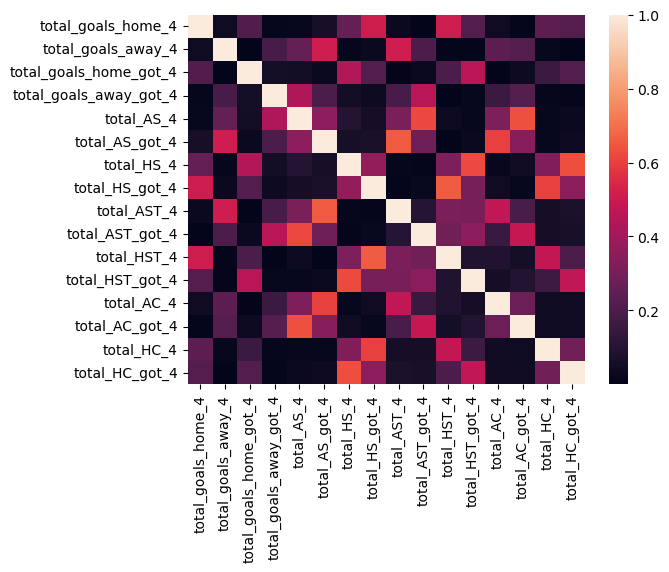

In [210]:
# Print out the correlation matrix
sns.heatmap(df_features.corr().abs())

<Axes: >

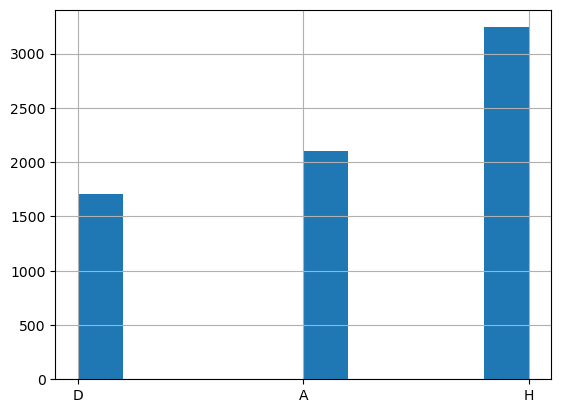

In [211]:
result.hist()

In [212]:
# Create correlation matrix
corr_matrix = df_features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
df_features.drop(to_drop, axis=1, inplace=True)

In [213]:
df_features.head()

,total_goals_home_4,total_goals_away_4,total_goals_home_got_4,total_goals_away_got_4,total_AS_4,total_AS_got_4,total_HS_4,total_HS_got_4,total_AST_4,total_AST_got_4,total_HST_4,total_HST_got_4,total_AC_4,total_AC_got_4,total_HC_4,total_HC_got_4
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [214]:
## Transform to numpy array
result = pd.factorize(result)
features = np.array(df_features)

scaler = Normalizer()

features = scaler.fit_transform(features)
result = np.array(result[0])
train_size = int(len(features) * 0.8)
X_train, X_val = features[:train_size], features[train_size:]
y_train, y_val = result[:train_size], result[train_size:]
# X_val, X_test = X_val[:len(X_val) // 2], X_val[len(X_val) // 2:]
# y_val, y_test = y_val[:len(y_val) // 2], y_val[len(y_val) // 2:]

## Function to return expected returns with specific bookmakers or maximum bet rate

In [215]:
def return_rate(y_pred, y_val, first_index, train_size):
    dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)
    test = []
    for i in range(0, len(y_val)):
        if(y_val[i] == y_pred[i]):
            if (y_val[i] == 0):
                test.append(dataset.iloc[first_index + train_size + i]['MaxD'])
            if (y_val[i] == 1):
                test.append(dataset.iloc[first_index + train_size + i]['MaxA'])    
            if (y_val[i] == 2):
                test.append(dataset.iloc[first_index + train_size + i]['MaxH'])
        else:
            test.append(0)
    print(test)
    print(sum(test) / len(test))

def decision_given_probability(y_pred_prob, first_index, train_size):
    dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)
    decision = []
    for i in range(0, len(y_val)):
        expected_return = []
        max_return = 0
        index_max = 0
        expected_return.append(dataset.iloc[first_index + train_size + i]['MaxD'] * y_pred_prob[i][0])
        expected_return.append(dataset.iloc[first_index + train_size + i]['MaxA'] * y_pred_prob[i][1])
        expected_return.append(dataset.iloc[first_index + train_size + i]['MaxH'] * y_pred_prob[i][2])
        for x in expected_return:
            if x > max_return:
                max_return = x
                index_max = expected_return.index(x)
        decision.append(index_max)
    return decision


## Train the model

In [216]:
##  OPTIONAL: RESAMPLING
# X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

### Main model

In [217]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
model = MLPClassifier((20, 20))
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)
y_pred = decision_given_probability(y_pred, start, train_size)
print(train_size)
print(y_pred)
print(y_val.tolist())

return_rate(y_pred, y_val, start, train_size)
print(accuracy_score(y_pred, y_val))

C:\Users\trung\AppData\Local\Temp\ipykernel_10532\1472246011.py:18: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)


5638
[2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2

C:\Users\trung\AppData\Local\Temp\ipykernel_10532\1472246011.py:2: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)


### Auxillary model

In [218]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)
y_pred = decision_given_probability(y_pred, start, train_size)
print(accuracy_score(y_pred, y_val))
return_rate(y_pred, y_val, start, train_size)

C:\Users\trung\AppData\Local\Temp\ipykernel_10532\1472246011.py:18: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)


0.2957446808510638
[4.3, 2.14, 0, 1.72, 1.19, 0, 1.46, 0, 0, 0, 11.31, 2.22, 0, 0, 0, 0, 4.1, 0, 0, 0, 0, 0, 0, 0, 6.7, 6.8, 0, 0, 2.35, 2.75, 5.6, 0, 0, 0, 0, 0, 4.1, 0, 0, 0, 0, 2.5, 0, 0, 0, 0, 0, 0, 0, 3.4, 0, 2.13, 0, 0, 0, 4.45, 0, 0, 0, 0, 2.25, 0, 0, 0, 1.35, 0, 2.04, 0, 0, 2.52, 0, 0, 11.0, 0, 0, 0, 0, 1.69, 2.81, 0, 0, 2.2, 0, 0, 0, 0, 11.5, 3.87, 2.62, 1.54, 0, 0, 0, 0, 0, 1.82, 1.6, 0, 4.15, 10.25, 0, 0, 1.53, 0, 0, 0, 4.35, 4.23, 3.5, 0, 0, 0, 0, 0, 0, 2.88, 0, 4.1, 0, 0, 2.1, 0, 0, 0, 2.85, 4.0, 0, 0, 2.56, 0, 0, 2.1, 0, 3.01, 1.44, 0, 0, 0, 4.33, 5.27, 0, 0, 4.35, 1.38, 0, 0, 0, 1.99, 2.9, 0, 0, 4.4, 0, 3.77, 2.72, 0, 0, 3.81, 6.55, 0, 0, 0, 2.12, 1.58, 0, 0, 0, 1.57, 0, 0, 3.32, 2.63, 0, 0, 0, 0, 0, 7.0, 0, 5.8, 0, 0, 0, 0, 0, 1.85, 0, 0, 0, 0, 0, 0, 0, 3.88, 3.79, 0, 2.06, 3.75, 0, 0, 2.01, 0, 4.45, 0, 0, 0, 0, 10.19, 0, 3.66, 0, 0, 2.48, 0, 0, 1.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.1, 2.58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.85, 0, 0, 0, 1.47, 0, 3.04, 0, 0, 17.75, 0, 2.5, 0, 2.

C:\Users\trung\AppData\Local\Temp\ipykernel_10532\1472246011.py:2: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)


In [219]:
from sklearn.svm import SVC

model = SVC(probability=True)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)
y_pred = decision_given_probability(y_pred, start, train_size)
print(accuracy_score(y_pred, y_val))
return_rate(y_pred, y_val, start, train_size)

C:\Users\trung\AppData\Local\Temp\ipykernel_10532\1472246011.py:18: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)


0.24964539007092199
[4.3, 2.14, 0, 0, 0, 0, 0, 0, 0, 0, 11.31, 2.22, 0, 0, 0, 0, 4.1, 0, 0, 0, 0, 0, 0, 0, 0, 6.8, 0, 2.16, 2.35, 2.75, 5.6, 0, 0, 0, 0, 0, 4.1, 0, 2.1, 0, 0, 2.5, 0, 0, 0, 0, 0, 0, 0, 3.4, 0, 2.13, 2.05, 0, 0, 0, 0, 0, 0, 0, 2.25, 0, 0, 0, 0, 0, 2.04, 0, 0, 2.52, 0, 0, 11.0, 0, 0, 0, 0, 0, 2.81, 0, 0, 0, 0, 0, 0, 0, 11.5, 3.87, 2.62, 0, 0, 0, 5.7, 0, 0, 0, 0, 0, 4.15, 10.25, 0, 0, 0, 0, 0, 0, 0, 4.23, 0, 0, 0, 0, 0, 0, 0, 2.88, 0, 4.1, 4.15, 0, 2.1, 0, 0, 0, 0, 4.0, 0, 0, 2.56, 0, 0, 2.1, 0, 0, 0, 0, 0, 0, 4.33, 5.27, 0, 0, 4.35, 0, 0, 0, 0, 0, 2.9, 0, 0, 0, 0, 3.77, 2.72, 0, 0, 3.81, 6.55, 0, 0, 0, 0, 0, 0, 0, 2.1, 0, 0, 0, 3.32, 2.63, 0, 0, 0, 0, 0, 7.0, 0, 5.8, 0, 0, 0, 0, 0, 0, 0, 4.04, 0, 0, 0, 2.53, 0, 0, 3.79, 0, 2.06, 3.75, 0, 0, 0, 0, 4.45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.48, 0, 0, 0, 0, 0, 0, 0, 2.09, 0, 0, 0, 0, 5.1, 2.58, 0, 0, 0, 0, 4.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.04, 0, 0, 17.75, 0, 2.5, 0, 2.18, 0, 4.03, 0, 0, 0, 12.0, 2.3, 6.7, 3.09, 0, 0, 0, 0, 0, 0

C:\Users\trung\AppData\Local\Temp\ipykernel_10532\1472246011.py:2: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('created_dataset/EPL_2005_2023.csv', index_col=None, header=0)


In [220]:
# import joblib
# model = joblib.load('trained_model/prediction_with_FCNN_last_4_matches.pkl')
inference = [0] * 16
home_team_name = 'Man United'
away_team_name = 'Man City'
# Features are: total_goals_home_4	total_goals_away_4	total_goals_home_got_4	total_goals_away_got_4	total_AS_4	total_AS_got_4	total_HS_4	total_HS_got_4	total_AST_4	total_AST_got_4	total_HST_4	total_HST_got_4	total_AC_4	total_AC_got_4	total_HC_4	total_HC_got_4
# These are the statistics of the last 4 games played by home and away teams.
# 'got' means the amount of goals/etc that the home/away teams have been scored by the opponents in the last 4 games that each team played.
# Output is [0, 1, 2], in which 0 is draw, 1 is away, 2 is home.
query_data_home = dataset[(dataset['HomeTeam'] == home_team_name) | (dataset['AwayTeam'] == home_team_name)][-5:-1]
query_data_away = dataset[(dataset['HomeTeam'] == away_team_name) | (dataset['AwayTeam'] == away_team_name)][-5:-1]
for i in range(0, 4):
    if query_data_home.iloc[i]['AwayTeam'] == home_team_name:
        inference[0] += query_data_home.iloc[i]['FTAG']
        inference[2] += query_data_home.iloc[i]['FTHG']
        inference[6] += query_data_home.iloc[i]['AS']
        inference[7] += query_data_home.iloc[i]['HS']
        inference[10] += query_data_home.iloc[i]['AST']
        inference[11] += query_data_home.iloc[i]['HST']
        inference[14] += query_data_home.iloc[i]['AC']
        inference[15] += query_data_home.iloc[i]['HC']
    if query_data_home.iloc[i]['HomeTeam'] == home_team_name:
        inference[0] += query_data_home.iloc[i]['FTHG']
        inference[2] += query_data_home.iloc[i]['FTAG']
        inference[6] += query_data_home.iloc[i]['HS']
        inference[7] += query_data_home.iloc[i]['AS']
        inference[10] += query_data_home.iloc[i]['HST']
        inference[11] += query_data_home.iloc[i]['AST']
        inference[14] += query_data_home.iloc[i]['HC']
        inference[15] += query_data_home.iloc[i]['AC']
    if query_data_home.iloc[i]['HomeTeam'] == away_team_name:
        inference[1] += query_data_home.iloc[i]['FTHG']
        inference[3] += query_data_home.iloc[i]['FTAG']
        inference[4] += query_data_home.iloc[i]['HS']
        inference[5] += query_data_home.iloc[i]['AS']
        inference[8] += query_data_home.iloc[i]['HST']
        inference[9] += query_data_home.iloc[i]['AST']
        inference[12] += query_data_home.iloc[i]['HC']
        inference[13] += query_data_home.iloc[i]['AC']
    if query_data_home.iloc[i]['AwayTeam'] == away_team_name:
        inference[1] += query_data_home.iloc[i]['FTAG']
        inference[3] += query_data_home.iloc[i]['FTHG']
        inference[4] += query_data_home.iloc[i]['AS']
        inference[5] += query_data_home.iloc[i]['HS']
        inference[8] += query_data_home.iloc[i]['AST']
        inference[9] += query_data_home.iloc[i]['HST']
        inference[12] += query_data_home.iloc[i]['AC']
        inference[13] += query_data_home.iloc[i]['HC']

prediction = int(model.predict(np.array(inference).reshape(1, -1)))
if prediction == 0:
    print('Draw')
if prediction == 1:
    print('Away')
if prediction == 2:
    print('Home')


Home


C:\Users\trung\AppData\Local\Temp\ipykernel_10532\2332219013.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(model.predict(np.array(inference).reshape(1, -1)))


In [221]:
# # Save the model to file
# import joblib
# filename = 'trained_model/prediction_with_FCNN_last_4_matches.pkl'
# joblib.dump(model, filename)